In [98]:
#importing data 

import requests
import pandas as pd
import json

url = "https://api.cin7.com/api/v1/Products"
query_params = {
    "rows": 250,
    #"where": "createdDate<2023-03-05T00:00:00Z and createdDate>2022-12-31T23:59:59Z",
    #"where": "createdDate<2023-02-01T00:00:00Z and createdDate>2022-12-31T23:59:59Z",
    "fields": "StyleCode, productOptions"
}

headers = {
    "Content-Type": "application/json"
}

auth = ("DiggsIncUS", "9901f725991a42c4b8ea12917e3c21d9")  # replace with your Cin7 username and password

data = []
page = 1
while True:
    query_params["page"] = page
    response = requests.get(url, headers=headers, params=query_params, auth=auth)
    if response.status_code == 200:
        
        # Append the data from the current page to the list of data
        data += response.json()
        # Check if there are more pages of data to fetch
        if len(response.json()) < 250:
            break
        else:
            page += 1
    else:
        print(f"Request failed with status code {response.status_code}")
        break

df = pd.json_normalize(data)


df.head()


,styleCode,productOptions
0,MCP001A42G,"[{'id': 967, 'createdDate': '2023-02-23T17:06:..."
1,MCP001A40G,"[{'id': 966, 'createdDate': '2023-02-23T17:05:..."
2,MCP001A36G,"[{'id': 965, 'createdDate': '2023-02-23T17:03:..."
3,MCP001A30G,"[{'id': 964, 'createdDate': '2023-02-23T17:02:..."
4,MCP001A24G,"[{'id': 963, 'createdDate': '2023-02-23T16:57:..."


In [99]:
df = df.explode('productOptions')
df.head(4)

,styleCode,productOptions
0,MCP001A42G,"{'id': 967, 'createdDate': '2023-02-23T17:06:3..."
1,MCP001A40G,"{'id': 966, 'createdDate': '2023-02-23T17:05:2..."
2,MCP001A36G,"{'id': 965, 'createdDate': '2023-02-23T17:03:5..."
3,MCP001A30G,"{'id': 964, 'createdDate': '2023-02-23T17:02:3..."


In [100]:
# Use json_normalize to flatten the 'lineItems' column
df_product_options = pd.json_normalize(df['productOptions'])

# Apply function to rename columns
df_product_options = df_product_options.rename(columns=lambda x: x.split(".")[-1])

In [101]:
df = df.reset_index(drop=True)
# Combine the flattened 'productOptions' DataFrame with the original DataFrame
df_data = pd.concat([df, df_product_options], axis=1)
df_data.head(3)

,styleCode,productOptions,id,createdDate,modifiedDate,status,productId,code,barcode,productOptionCode,...,specialsStartDate,specialDays,stockAvailable,stockOnHand,image,retailUSD,vipusd,wholesaleUSD,costUSD,specialPrice
0,MCP001A42G,"{'id': 967, 'createdDate': '2023-02-23T17:06:3...",967,2023-02-23T17:06:32Z,2023-02-23T17:06:32Z,Active,1006,MCP001A42G,,MCP001A42G,...,None,0,0.0,0.0,None,0.0,0.0,0.0,16.30,0.0
1,MCP001A40G,"{'id': 966, 'createdDate': '2023-02-23T17:05:2...",966,2023-02-23T17:05:23Z,2023-02-23T17:05:23Z,Active,1005,MCP001A40G,,MCP001A40G,...,None,0,0.0,0.0,None,0.0,0.0,0.0,11.85,0.0
2,MCP001A36G,"{'id': 965, 'createdDate': '2023-02-23T17:03:5...",965,2023-02-23T17:03:52Z,2023-02-23T17:03:52Z,Active,1004,MCP001A36G,,MCP001A36G,...,None,0,0.0,0.0,None,0.0,0.0,0.0,8.86,0.0


In [102]:
# Drop the original 'lineItems' column
df_data = df_data.drop('productOptions', axis=1)


In [103]:
df_data = df_data.drop(['modifiedDate', 'productOptionCode', 'productOptionSizeCode',
       'productOptionBarcode', 'barcode', 'supplierCode', 'productOptionSizeBarcode','optionWeight', 'size', 'retailPrice',
       'wholesalePrice', 'vipPrice', 'specialPrice', 'specialsStartDate',
       'specialDays',  'image', 'retailUSD',
       'vipusd', 'wholesaleUSD', 'costUSD', 'specialPrice'], axis=1)

df_data.head(3)


,styleCode,id,createdDate,status,productId,code,option1,option2,option3,stockAvailable,stockOnHand
0,MCP001A42G,967,2023-02-23T17:06:32Z,Active,1006,MCP001A42G,grey,XL,,0.0,0.0
1,MCP001A40G,966,2023-02-23T17:05:23Z,Active,1005,MCP001A40G,grey,Lg,,0.0,0.0
2,MCP001A36G,965,2023-02-23T17:03:52Z,Active,1004,MCP001A36G,grey,Int,,0.0,0.0


In [104]:
#import excel file

sku_mapping_df = pd.read_excel('/Users/revatirameshkharate/Desktop/ITP Projects/Diggs BI/Diggs SKU Mapping.xlsx', sheet_name='Sheet1')
sku_mapping_df.head()


,Diggs SKU,Product Title,Variant,Category,Color,Size,Is Bundle?,Component 1,Component 2,Component 3,Component 4
0,WSC007AALW,Collar,Collar - Large - Ash,Walk,Ash,Large,N,NaN,NaN,NaN,NaN
1,WSC012AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,N,NaN,NaN,NaN,NaN
2,WSC040AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,N,NaN,NaN,NaN,NaN
3,WSC008AALB,Collar,Collar - Large - Charcoal,Walk,Charcoal,Large,N,NaN,NaN,NaN,NaN
4,WSC016AALL,Collar,Collar - Large - Lilac,Walk,Lilac,Large,N,NaN,NaN,NaN,NaN


In [105]:
#mergeing
sku_mapping_df.rename(columns = {'Diggs SKU':'styleCode'}, inplace = True)

stock_data = pd.merge(df_data, sku_mapping_df, on='styleCode')

In [106]:
#stock_data2 = stock_data.drop(stock_data.columns[3],axis = 1)

stock_data.head()

,styleCode,id,createdDate,status,productId,code,option1,option2,option3,stockAvailable,...,Product Title,Variant,Category,Color,Size,Is Bundle?,Component 1,Component 2,Component 3,Component 4
0,TPD001AOSC,940,2022-11-14T22:04:31Z,Active,979,TPD001AOSC,,,,0.0,...,Passenger,Passenger/Pee Pad Bundle - Charcoal,Travel,Charcoal,NaN,Y,Passenger - Charcoal,Pee Pads,NaN,NaN
1,WBD001AA4I,939,2022-11-14T21:59:15Z,Active,978,WBD001AA4I,,,,0.0,...,Poop Bags,Poop Bags 4x Bundle,Walk,NaN,NaN,Y,WSP002AA08I,WSP002AA08I,WSP002AA08I,WSP002AA08I
2,WBD001AA2I,938,2022-11-14T21:58:57Z,Active,977,WBD001AA2I,,,,0.0,...,Poop Bags,Poop Bags 2x Bundle,Walk,NaN,NaN,Y,WSP002AA08I,WSP002AA08I,NaN,NaN
3,DBD001STDP,937,2022-11-14T21:58:44Z,Active,976,DBD001STDP,,,,0.0,...,Dispenser,Dispenser / Poop Bag Bundle - Blush,Walk,Blush,NaN,Y,Dispenser - Blush,Poop Bags,Poop Bags,NaN
4,DBD001STDG,936,2022-11-14T21:58:31Z,Active,975,DBD001STDG,,,,0.0,...,Dispenser,Dispenser / Poop Bag Bundle - Grey,Walk,Grey,NaN,Y,Dispenser - Grey,Poop Bags,Poop Bags,NaN


In [110]:
# filter data for a specific date range
#start_date = '2022-11-01'
#end_date = '2023-03-05'
#filtered_stock_data = stock_data[(stock_data['createdDate'] >= start_date) & (stock_data['createdDate'] <= end_date)]

#filtered_stock_data.head()

,styleCode,id,createdDate,status,productId,code,option1,option2,option3,stockAvailable,...,Product Title,Variant,Category,Color,Size,Is Bundle?,Component 1,Component 2,Component 3,Component 4
0,TPD001AOSC,940,2022-11-14T22:04:31Z,Active,979,TPD001AOSC,,,,0.0,...,Passenger,Passenger/Pee Pad Bundle - Charcoal,Travel,Charcoal,NaN,Y,Passenger - Charcoal,Pee Pads,NaN,NaN
1,WBD001AA4I,939,2022-11-14T21:59:15Z,Active,978,WBD001AA4I,,,,0.0,...,Poop Bags,Poop Bags 4x Bundle,Walk,NaN,NaN,Y,WSP002AA08I,WSP002AA08I,WSP002AA08I,WSP002AA08I
2,WBD001AA2I,938,2022-11-14T21:58:57Z,Active,977,WBD001AA2I,,,,0.0,...,Poop Bags,Poop Bags 2x Bundle,Walk,NaN,NaN,Y,WSP002AA08I,WSP002AA08I,NaN,NaN
3,DBD001STDP,937,2022-11-14T21:58:44Z,Active,976,DBD001STDP,,,,0.0,...,Dispenser,Dispenser / Poop Bag Bundle - Blush,Walk,Blush,NaN,Y,Dispenser - Blush,Poop Bags,Poop Bags,NaN
4,DBD001STDG,936,2022-11-14T21:58:31Z,Active,975,DBD001STDG,,,,0.0,...,Dispenser,Dispenser / Poop Bag Bundle - Grey,Walk,Grey,NaN,Y,Dispenser - Grey,Poop Bags,Poop Bags,NaN


In [111]:
# group by products sold high level view

summarized_df = pd.DataFrame(stock_data.groupby('Product Title').agg({'stockAvailable': 'sum'}).reset_index())

summarized_df = summarized_df.sort_values(by='stockAvailable', ascending=False)

summarized_df.head()

,Product Title,stockAvailable
5,Groov,48036.0
13,Revol,21782.0
3,Collar,21766.0
7,Leash,21022.0
4,Dispenser,12603.0


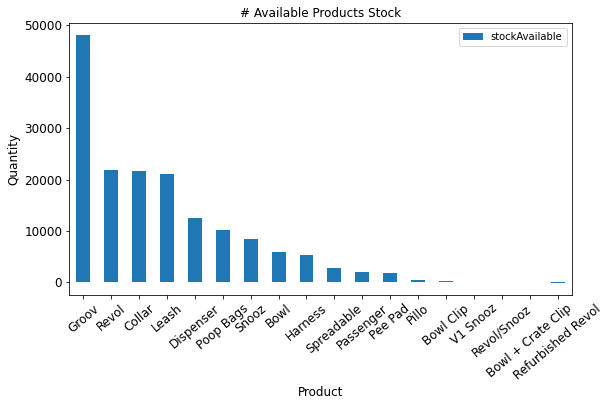

In [113]:
import matplotlib.pyplot as plt

fig1 = summarized_df.plot(kind = 'bar', x= 'Product Title', y ='stockAvailable', title ="# Available Products Stock", figsize=(9, 5), legend=True, fontsize=12)

fig1.set_xlabel("Product", fontsize=12)
fig1.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()


In [114]:
#grouping 

# group by products variant
available_stock_variant = stock_data.groupby('Variant')['stockAvailable'].sum().sort_values(ascending=False)

available_stock_variant_df = available_stock_variant.to_frame()
available_stock_variant_df.head(5)

,stockAvailable
Variant,
Groov - Blush,16519.0
Groov - Navy,12568.0
Groov - Turquoise,10673.0
Poop Bags,10211.0
Groov - Lilac,3921.0


In [123]:
top10_df = available_stock_variant.head(10)
bottom10_df = available_stock_variant.tail(10)


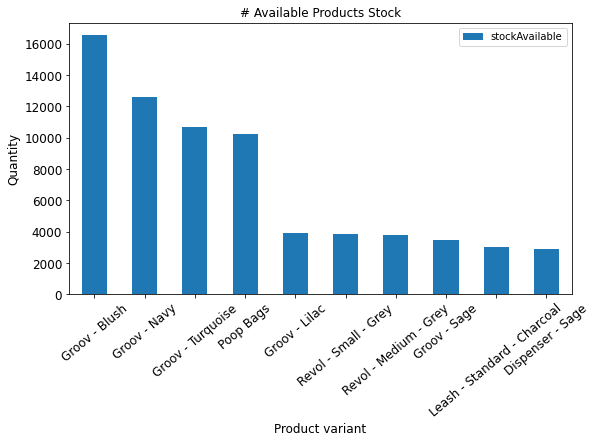

In [124]:
fig2 = top10_df.plot(kind = 'bar', title ="# Available Products Stock", figsize=(9, 5), legend=True, fontsize=12)

fig2.set_xlabel("Product variant", fontsize=12)
fig2.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()

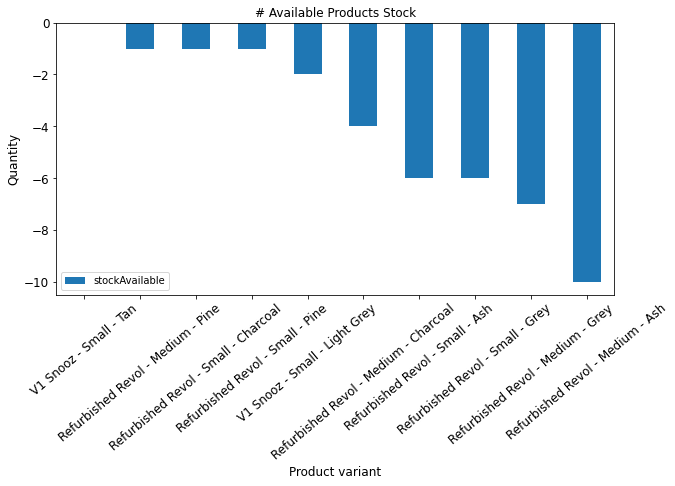

In [125]:
fig3 = bottom10_df.plot(kind = 'bar', title ="# Available Products Stock", figsize=(10, 5), legend=True, fontsize=12)

fig3.set_xlabel("Product variant", fontsize=12)
fig3.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()


In [126]:
no_stock_avail_df = available_stock_variant_df[available_stock_variant_df["stockAvailable"] == 0]
print(no_stock_avail_df) #31 products which have no inventory

                                        stockAvailable
Variant                                               
Revol/Snooz Bundle - Medium - Ash                  0.0
Spreadable Treat Variety Pack                      0.0
V1 Snooz - Medium - Tan                            0.0
Revol - Medium - Pine                              0.0
Revol/Snooz Bundle - Large - Grey                  0.0
Revol/Snooz Bundle - Medium - Grey                 0.0
V1 Snooz - Medium - Light Grey                     0.0
Revol/Snooz Bundle - Large - Ash                   0.0
Revol/Snooz Bundle - Medium - Charcoal             0.0
Revol/Snooz Bundle - Large - Charcoal              0.0
Crate Bowl + Clip S/M Ash                          0.0
Revol - Large - Ash                                0.0
Revol - Int - Grey                                 0.0
Crate Bowl + Clip I/L Charcoal                     0.0
Crate Bowl + Clip I/L Ash                          0.0
Dispenser / Poop Bag Bundle - Ash                  0.0
Dispenser 